In [ ]:
!pip install pydub

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pydub import AudioSegment

In [ ]:
#Splitting the Dataset
import tensorflow as tf

# Define your dataset directory
directory = '/content/drive/MyDrive/Spectrograms_Accent_Detection'

# Create the dataset using image_dataset_from_directory
full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=1337,
    validation_split=0.15,
    subset='training'
)

# Calculate the number of samples in the full dataset
num_samples = full_dataset.cardinality().numpy()

# Calculate the number of samples for testing and validation
num_test_samples = int(0.15 * num_samples)  # 15% for testing
num_validation_samples = int(0.15 * num_samples)  # 15% for validation

# Create the test dataset by skipping the training and validation samples
test_dataset = full_dataset.skip(num_samples - num_test_samples)

# Create the training dataset by taking the first 75% of samples
train_dataset = full_dataset.take(int(0.75 * num_samples))

# Create the validation dataset by skipping the training samples and taking the next 15%
validation_dataset = full_dataset.skip(int(0.75 * num_samples)).take(num_validation_samples)

# Print the number of samples in each dataset
print(f"Number of training samples: {int(0.75 * num_samples)}")
print(f"Number of validation samples: {num_validation_samples}")
print(f"Number of test samples: {num_test_samples}")


Found 1334 files belonging to 15 classes.
Using 1134 files for training.
Number of training samples: 27
Number of validation samples: 5
Number of test samples: 5


In [ ]:
#Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Data Normalization
data_normalization = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
])

train_dataset = train_dataset.map(
    lambda x, y: (data_normalization(x), y)
)

validation_dataset = validation_dataset.map(
    lambda x, y: (data_normalization(x), y)
)

test_dataset = test_dataset.map(
    lambda x, y: (data_normalization(x), y)
)

Found 1334 files belonging to 15 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (C

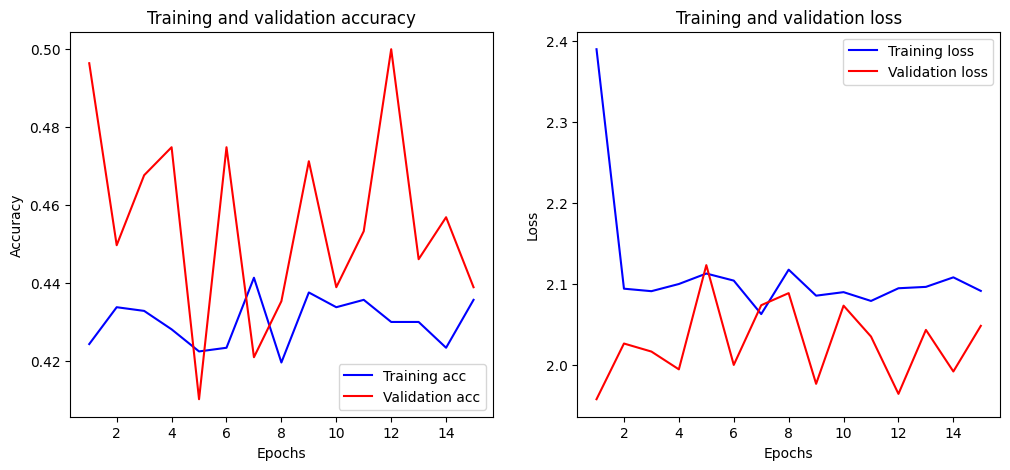

NameError: ignored

In [ ]:
#Training Classification to model using Spectrograms with CNN layers
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

directory = '/content/drive/MyDrive/Spectrograms_Accent_Detection'

dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=1337,
)

num_batches = len(dataset)
train_size = int(0.8 * num_batches)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Reshape((1, -1)),  # Add a temporal dimension
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
])

# Print the model summary to get the output shape of the last convolutional layer
model.build((None, 256, 256, 3))
model.summary()

model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='softmax'))  # Assuming 15 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
